# Model Runs per Half Inning With Linear Regression

Runs scored per half-inning will be modeled using multivariate linear regression for singles, doubles, triples, home runs, and other types of plays.

Linear regression models are good explanatory models.  The coefficient in front of "singles" for example, tells how much each single contributes towards scoring a run.

The model will be created using all half-innings of play through the 8th inning for all games from the year 2000 onward.  This is more than 750K half-innings.  

The first step is to create a DataFrame that has stats per half inning.  As the output of the cwevent parser is missing some necessary fields, I have added these fields by parsing the Retrosheet event file using regular expressions.  These new fields were verified to be 100% consistent with those created by the cwgame parser.

## Baseball Assumptions
* The goal of each offensive half-inning is to score as many runs as possible
* The goal of each defensive half-inning is to allow as few runs as possible
  
The above assumptions are not entirely correct for the home half of the 9th or later innings in which the offensive team is trying to end the game with a win, and the defensive team is trying to prevent the game from ending with a loss.  To account for this, only the first 8 innings of play will be used.

Some games have less than 8 complete innings.  This is usually due to rain.  As it is difficult for either team to predict when an umpire will call a game short of the 9th, the strategy employed in the bottom of the 9th or later, arguably does not apply in these games.  Shortened games will be included in the model.  Shortened games are rare, making up only 0.3% of all games since 2000.

### Linear Regression Assumptions
There are 4 assumptions that should be checked before using the results of ordinary least squares (OLS).
1. Is there a linear relationship between the target variable and the inputs?
   * There is reason to expect that the number of runs in a half-inning is linearly dependent on such factors as the number of singles, doubles, triples, and home runs.
   * The percent of variance explained is high for the model presented below.
   * This condition appears to be met.
2. Is there [multicollinearity](https://en.wikipedia.org/wiki/Multicollinearity)?
   * If there is, this could strongly affect the values of the coefficients in the model.
   * The model presented below does not have multicolinearity.
3. Are the residuals [homoscedastic](https://en.wikipedia.org/wiki/Homoscedasticity)?
   * This was checked and found to be false.  The higher the predicted number of runs, the higher the variance of the residual.
   * This means that the confidence intervals computed by OLS are not accurate.
   * The confidence intervals can be computed by using a bootstrap.
4. Are the [residuals normally distributed](https://thestatsgeek.com/2013/08/07/assumptions-for-linear-regression/)?
   * This is only an issue for small sample sizes.  Here there are over 750K observations, so this condition does not have to be met.

## Fields Added to Output of cwevent
This section describes the details of the parsing of the Retrosheet data.

The cwevent parser output is described at: http://chadwick.sourceforge.net/doc/cwevent.html

cwevent does not produce a field for so, sb, cs, bk, bb, ibb, hbp, and xi. These fields were added by custom parsing of the cwevent field, event_tx.  This was done prior to creating the wrangled event csv file.

cwevent also has a h_cd field with values of 1, 2, 3, 4 for single, double, triple, home run, but for ease of processing, a boolean field was added for each.  When the event data is grouped by half-inning, the boolean values can be summed to get the total number of singles, doubles, triples, and home runs per half-inning.

As cwevent has been used and tested for years, I made no attempt to rewrite it.  Rather I augmented its output by parsing its event_tx field, and then verified that when aggregated, these new fields exactly match the output of the cwgame parser.

In [1]:
import os
import pandas as pd
import numpy as np
from pathlib import Path
import re
import random

In [2]:
import sys

# import data_helper.py from download_scripts directory
sys.path.append('../download_scripts')
import data_helper as dh

In [3]:
# Linear Regression modules
import statsmodels.api as sm
import statsmodels.formula.api as smf
from patsy import dmatrices

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [5]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 100 # increase dpi, will make figures larger and clearer

In [6]:
data_dir = Path('../data')
lahman_data = data_dir.joinpath('lahman/wrangled').resolve()
retrosheet_data = data_dir.joinpath('retrosheet/wrangled').resolve()

## Read in the Data

In [7]:
# This may be a very large dataframe if many years were parsed and/or many fields were selected
event = dh.from_csv_with_types(retrosheet_data / 'event.csv.gz')
event.shape

(10483615, 42)

In [8]:
pd.set_option('display.max_columns', 50)
event.head(3)

,game_id,inn_ct,home_half,away_score_ct,home_score_ct,bat_id,pit_id,event_tx,h_cd,outs,e,event_id,team_id,opponent_team_id,inn_runs_ct,start_bases_cd,end_bases_cd,r,fate_runs_ct,ab,sh,sf,dp,tp,wp,pb,inn_end,pa,bat_safe_err,so,sb,cs,bk,ibb,bb,hbp,xi,single,double,triple,hr,h
0,BAL195504120,1,0,0,0,goodb101,colej101,S,1,0,0,1,BOS,BAL,0,0,1,0,1,True,False,False,False,False,False,False,False,True,False,False,0,0,False,False,False,False,False,True,False,False,False,True
1,BAL195504120,1,0,0,0,joose101,colej101,S7.1-3,1,0,0,2,BOS,BAL,0,1,5,0,1,True,False,False,False,False,False,False,False,True,False,False,0,0,False,False,False,False,False,True,False,False,False,True
2,BAL195504120,1,0,0,0,throf101,colej101,64(1)/FO.3-H,0,1,0,3,BOS,BAL,0,5,1,1,0,True,False,False,False,False,False,False,False,True,False,False,0,0,False,False,False,False,False,False,False,False,False,False


In [9]:
# as most processing is done by year, add a year column
event['year'] = event['game_id'].str[3:7].astype('int')

In [10]:
# for now, just consider half-innings since 2000
event = event.query('year >= 2000')
event.shape

(3846595, 43)

In [11]:
# what percent of official games are shorter than 9 innings?
# the game csv file has the number of innings for each game
game = dh.from_csv_with_types(retrosheet_data / 'game.csv.gz')
game['year'] = game['game_start'].dt.year
game = game.query('year >= 2000')

np.round(game.query('inn_ct < 9')['inn_ct'].count() / len(game), 3)

0.003

In [12]:
# Alternative calculation
# 8 complete innings is 8 * 3 * 2 = 48 outs
np.round(game.query('outs_ct < 48')['outs_ct'].count() / len(game), 3)

0.003

The above shows that 99.7% of all games have at least 8 complete innings of play.

In [13]:
# remove the 9th and later innings
event_8 = event.query('inn_ct < 9')

In [14]:
# these play-by-play columns will be aggregated to the half-inning
agg_cols = ['pb', 'wp', 'dp', 'bb', 'outs', 'so', 'hbp', 'triple', 'single', 'tp', 'sf',
            'r', 'double', 'pa', 'bat_safe_err', 'h', 'sb', 'sh', 'ibb', 'ab', 'cs',
            'hr', 'xi', 'e', 'bk']

In [15]:
# group by half-inning
key = ['game_id', 'inn_ct', 'home_half']
inn_8 = event_8[key + agg_cols].groupby(key).agg('sum')

In [16]:
inn_8.head(17)

pb   wp   dp   bb  outs   so  hbp  triple  \
game_id      inn_ct home_half                                               
ANA200004030 1      0          0.0  0.0  0.0  1.0     3  0.0  0.0     0.0   
                    1          0.0  0.0  1.0  0.0     3  1.0  0.0     0.0   
             2      0          0.0  0.0  0.0  1.0     3  0.0  0.0     0.0   
                    1          0.0  0.0  0.0  1.0     3  0.0  0.0     0.0   
             3      0          0.0  0.0  0.0  0.0     3  0.0  0.0     0.0   
                    1          0.0  0.0  0.0  0.0     3  1.0  0.0     0.0   
             4      0          0.0  0.0  0.0  0.0     3  1.0  0.0     0.0   
                    1          0.0  0.0  0.0  0.0     3  0.0  0.0     0.0   
             5      0          0.0  0.0  0.0  1.0     3  1.0  0.0     0.0   
                    1          0.0  0.0  0.0  0.0     3  1.0  0.0     0.0   
             6      0          0.0  0.0  0.0  0.0     3  0.0  0.0     0.0   
                    1          0.0  0.0  0.0  2.0     3  1.0  0.0     0.0   
             7      0          0.0  0.0  0.0  0.0     3  0.0  0.0     0.0   
                    1          0.0  0.0  0.0  0.0     3  0.0  0.0     0.0   
             8      0          0.0  0.0  0.0  0.0     3  1.0  0.0     0.0   
                    1          0.0  0.0  0.0  1.0     3  1.0  0.0     0.0   
ANA200004040 1      0          0.0  0.0  0.0  1.0     3  0.0  0.0     0.0   

                               single   tp   sf  r  double   pa  bat_safe_err  \
game_id      inn_ct home_half                                                   
ANA200004030 1      0             1.0  0.0  0.0  0     0.0  4.0           0.0   
                    1             1.0  0.0  0.0  0     0.0  3.0           0.0   
             2      0             0.0  0.0  0.0  0     0.0  4.0           0.0   
                    1             1.0  0.0  0.0  1     0.0  5.0           0.0   
             3      0             0.0  0.0  0.0  0     0.0  3.0           0.0   
                    1             0.0  0.0  0.0  0     1.0  4.0           0.0   
             4      0             1.0  0.0  0.0  0     0.0  3.0           0.0   
                    1             0.0  0.0  0.0  0     0.0  3.0           0.0   
             5      0             0.0  0.0  0.0  0     0.0  5.0           1.0   
                    1             3.0  0.0  0.0  0     0.0  6.0           0.0   
             6      0             2.0  0.0  0.0  2     0.0  6.0           0.0   
                    1             0.0  0.0  0.0  0     0.0  5.0           0.0   
             7      0             0.0  0.0  0.0  1     0.0  4.0           0.0   
                    1             1.0  0.0  0.0  0     0.0  4.0           0.0   
             8      0             0.0  0.0  0.0  0     0.0  3.0           0.0   
                    1             0.0  0.0  0.0  0     0.0  4.0           0.0   
ANA200004040 1      0             1.0  0.0  0.0  0     0.0  5.0           0.0   

                                 h  sb   sh  ibb   ab  cs   hr   xi  e   bk  
game_id      inn_ct home_half                                                
ANA200004030 1      0          1.0   0  0.0  0.0  3.0   1  0.0  0.0  0  0.0  
                    1          1.0   0  0.0  0.0  3.0   0  0.0  0.0  0  0.0  
             2      0          0.0   0  0.0  0.0  3.0   0  0.0  0.0  0  0.0  
                    1          2.0   0  0.0  0.0  4.0   1  1.0  0.0  0  0.0  
             3      0          0.0   0  0.0  0.0  3.0   0  0.0  0.0  0  0.0  
                    1          1.0   0  0.0  0.0  4.0   0  0.0  0.0  0  0.0  
             4      0          1.0   0  0.0  0.0  3.0   1  0.0  0.0  0  0.0  
                    1          0.0   0  0.0  0.0  3.0   0  0.0  0.0  0  0.0  
             5      0          0.0   0  0.0  0.0  4.0   0  0.0  0.0  1  0.0  
                    1          3.0   0  0.0  0.0  6.0   0  0.0  0.0  0  0.0  
             6      0          3.0   0  0.0  0.0  6.0   0  1.0  0.0  0  0.0  
              

In [17]:
# spot check the above
usecols = ['game_id', 'bat_last', 'team_id', 'opponent_team_id', 'r', 'h', 'e',
           'lob', 'line_tx', 'ab', 'double', 'triple', 'hr']
team_game = dh.from_csv_with_types(retrosheet_data / 'team_game.csv.gz', usecols=usecols)
team_game.query('game_id == "ANA200004030"')

,game_id,bat_last,team_id,opponent_team_id,r,h,e,lob,line_tx,ab,double,triple,hr
167420,ANA200004030,True,ANA,NYA,2,10,1,11,010000001,35,1,0,1
167421,ANA200004030,False,NYA,ANA,3,6,0,5,000002100,32,0,0,2


The line score shows that after 8 innings of play, 4 runs had been scored.  This agrees with the play-by-play data aggregated to the half-inning level displayed above.

In [18]:
# bb (base on balls) is defined to include ibb (intentional base on balls)
# create a new column for unintentional base on balls
inn_8['ubb'] = inn_8['bb'] - inn_8['ibb']

The manager of the team on the field opts for an intentional walk to reduce the number of runs in a potentially high scoring situation.

An unintentional walk would be expected to result in more runs than an intentional walk, as the intentional walk is intended to reduce the number of runs scored.  However since intentional walks are only issued in potentially high scoring situations, intentional walks will be positively correlated with runs.

Intentional walks are rare in the first 8 innings of play.

In [19]:
# average number of times each event occurs in a half-inning
inn_8.mean()

pb              0.007563
wp              0.036643
dp              0.103954
bb              0.357514
outs            2.999849
so              0.790901
hbp             0.039606
triple          0.021022
single          0.658867
tp              0.000094
sf              0.030968
r               0.519664
double          0.202162
pa              4.308033
bat_safe_err    0.039963
h               1.003564
sb              0.064520
sh              0.031648
ibb             0.023166
ab              3.837282
cs              0.026264
hr              0.121513
xi              0.000595
e               0.069912
bk              0.003552
ubb             0.334348
dtype: float64

### Field Descriptions
pb = passed ball  
wp = wild pitch  
bk = balk  
dp = double play  
tp = triple play  
bb = base on balls  
ibb = intentional base on balls  
outs = will always be 3 when aggregated to the half-inning  
so = strike outs  
hbp = hit by pitch  
sf = sacrifice fly  
sh = sacrifice bunt (aka sacrifice hit)  
sb = stolen base  
cs = caught stealing  
ab = at bat  
pa = plate appearance  
bat_safe_err = batter reaches on error  
xi = batter reaches on interference  
e = error  
h = hit  

Single, double, triple and hr are self-explanatory.

## Creating the Linear Model
The choice of which variables to include is not obvious.

A high value for R squared (or adjusted R squared) is the aim, as this implies the model fits the data well. However the ability to explain as simply as possible what causes runs to be scored, is also a goal.

Use of very rare plays, such as a triple play, is unlikely to improve the accuracy of the model because there is too little data to support it.

Use of variables which neither help nor hurt, makes the model harder to understand.

The following dependent variables were chosen by experimentation to be a small number of variables which have a good adjusted R squared value.

In [20]:
# perhaps the easiest way to specify the dependent variables is to use R formula notation
formula = 'r ~ ubb + ibb + hbp + single + double +triple +hr +sf +dp +e'
model = smf.ols(formula=formula, data=inn_8)
result = model.fit()
# print(result.summary())

In [21]:
# 78% of the variance is explained by the linear model
np.round(result.rsquared_adj, 2)

0.78

In [22]:
# number of observations used to build model
result.nobs

776987.0

In [23]:
# the coefficients of the linear model
np.round(result.params, 2)

Intercept   -0.29
ubb          0.34
ibb          0.22
hbp          0.38
single       0.48
double       0.73
triple       0.96
hr           1.39
sf           0.54
dp          -0.29
e            0.45
dtype: float64

### Confidence Intervals (CI)
As noted above, the variance of the residuals was found to depend on the predicted number of runs.  This means that result.conf_int(), the confidence intervals as calculated by smf.ols, are not correct.  Use a bootstrap to get the confidence intervals.

In [24]:
# Bootstrap
cols = np.append(result.params.index.values, 'r_squared_adj')
df = pd.DataFrame(columns=cols)
np.random.seed(100)
bootstrap_replicates = 500
print('Progress')
for b in range(bootstrap_replicates):
    idx = np.random.choice(range(len(inn_8)), size=len(inn_8), replace=True)
    model = smf.ols(formula=formula, data=inn_8.iloc[idx])
    result = model.fit()
    if not (b+1) % 5:
        print(f'{(b+1)*100/bootstrap_replicates:5.1f}%', end=' ')
    tmp = result.params.to_frame().T
    tmp['r_squared_adj'] = result.rsquared_adj
    df = df.append(tmp, ignore_index=True)

Progress
  1.0%   2.0%   3.0%   4.0%   5.0%   6.0%   7.0%   8.0%   9.0%  10.0%  11.0%  12.0%  13.0%  14.0%  15.0%  16.0%  17.0%  18.0%  19.0%  20.0%  21.0%  22.0%  23.0%  24.0%  25.0%  26.0%  27.0%  28.0%  29.0%  30.0%  31.0%  32.0%  33.0%  34.0%  35.0%  36.0%  37.0%  38.0%  39.0%  40.0%  41.0%  42.0%  43.0%  44.0%  45.0%  46.0%  47.0%  48.0%  49.0%  50.0%  51.0%  52.0%  53.0%  54.0%  55.0%  56.0%  57.0%  58.0%  59.0%  60.0%  61.0%  62.0%  63.0%  64.0%  65.0%  66.0%  67.0%  68.0%  69.0%  70.0%  71.0%  72.0%  73.0%  74.0%  75.0%  76.0%  77.0%  78.0%  79.0%  80.0%  81.0%  82.0%  83.0%  84.0%  85.0%  86.0%  87.0%  88.0%  89.0%  90.0%  91.0%  92.0%  93.0%  94.0%  95.0%  96.0%  97.0%  98.0%  99.0% 100.0% 

In [25]:
df.head()

,Intercept,ubb,ibb,hbp,single,double,triple,hr,sf,dp,e,r_squared_adj
0,-0.287372,0.343623,0.217571,0.376444,0.483888,0.726296,0.956602,1.389528,0.541217,-0.292450,0.448279,0.784712
1,-0.287839,0.344101,0.221882,0.376571,0.482397,0.727305,0.956258,1.392461,0.541095,-0.290688,0.452869,0.783934
2,-0.287455,0.343063,0.221997,0.373755,0.483418,0.726135,0.963209,1.390702,0.538645,-0.289508,0.446392,0.783704
3,-0.286459,0.342599,0.214315,0.375079,0.481128,0.725336,0.971409,1.388788,0.548419,-0.293203,0.446324,0.783576
4,-0.286948,0.341719,0.224268,0.371506,0.482714,0.726579,0.950412,1.392042,0.542410,-0.288134,0.446832,0.783968


In [26]:
# 95% confidence intervals (CI)
df.quantile(q=[0.025, 0.975]).round(3)

,Intercept,ubb,ibb,hbp,single,double,triple,hr,sf,dp,e,r_squared_adj
0.025,-0.290,0.340,0.206,0.367,0.482,0.723,0.950,1.386,0.533,-0.294,0.443,0.783
0.975,-0.286,0.346,0.232,0.384,0.487,0.731,0.972,1.395,0.549,-0.288,0.456,0.785


The above confidence intervals are pretty narrow.  For example, the 95% CI for a home run is between 1.386 and 1.395.

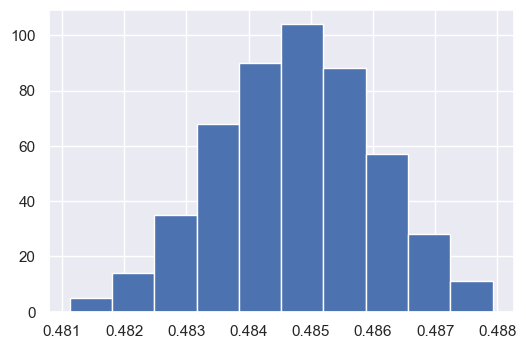

In [27]:
# Look at a couple of histograms to see if the bootstrap sampling distributions
# are approximately normal.
df['single'].hist();

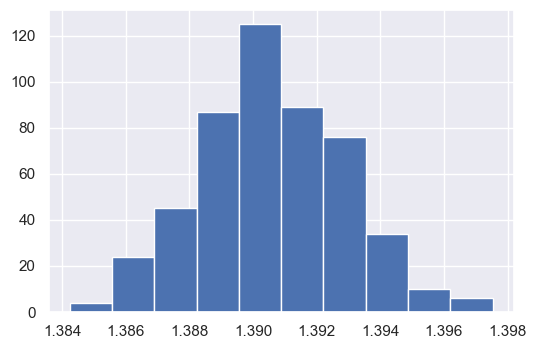

In [28]:
df['hr'].hist();

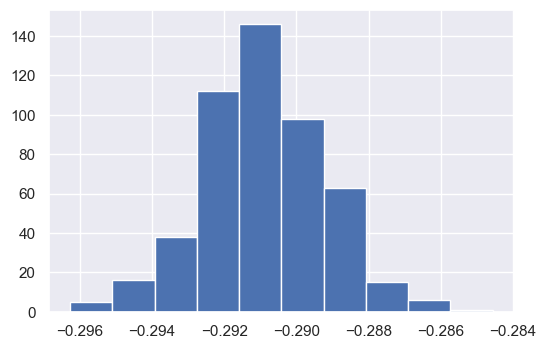

In [29]:
df['dp'].hist();

In [30]:
# Single, Double, Triple, and Home Run  coefficients
coeff = df.quantile(q=0.5)
single = coeff['single']
double = coeff['double']
triple = coeff['triple']
hr = coeff['hr']

print(f'{single:4.2f} {double:4.2f} {triple:4.2f} {hr:4.2f}')

0.48 0.73 0.96 1.39


In [31]:
# all the coefficients
df.quantile(q=0.5).round(2)

Intercept       -0.29
ubb              0.34
ibb              0.22
hbp              0.38
single           0.48
double           0.73
triple           0.96
hr               1.39
sf               0.54
dp              -0.29
e                0.45
r_squared_adj    0.78
Name: 0.5, dtype: float64

## Interpreting the Linear Model

### Intentional and Unintentional Walks, Hit by Pitch
* intentional walk (ibb): 0.22
* unintentional walk (ubb): 0.34
* hit-by-pitch (hbp): 0.38

Intentional walks are associated with less runs than unintentional walks.  This is expected as a manager decided that an intentional walk would reduce the total number of runs scored for the given situation.

Unintentional walks are associated with about the same number of runs as a hit-by-pitch.  This is expected as the outcome on the bases is the same for each. 

### Error, Single, Sacrifice Fly
* error: 0.45
* single: 0.48
* sacrifice fly (sf): 0.54

It is reasonable to expect these to be similar.   
An error:
* may advance the runners
* may allow the batter to reach base
* may allow the batter to have an extra chance to hit (when a foul ball is dropped)

A single:
* usually advances the runners
* always allows the batter to reach base

A sacrifice fly:
* always advances one or more runners

It may be that a sacrifice fly is associated with slightly more runs because the scenarios in which it can occur are more favorable to run scoring. This leads to the concept of the Run Expectancy Matrix which will be covered in a later notebook.

### Single, Double, Triple, Home Run
* single: 0.48
* double: 0.73
* triple: 0.96
* home run (hr): 1.39 

It is interesting to see that a double is not worth twice a single, a triple is not worth three times a single, and a home run in not worth four times a single.

When a batter's [slugging percentage](http://m.mlb.com/glossary/standard-stats/slugging-percentage) is computed, a single counts as 1.0, a double 2.0, a triple 3.0 and a home run 4.0.  If we consider the value of the offensive play to be associated with the number of runs it creates, then slugging percentage overvalues extra base hits.

In Sabermetrics, there is the concept of a weighted-on-base-average (wOBA) that uses weights for single, double, triple and home run that are similar to those computed above.  This metric is more reflective of the value of a batter than slugging percentage or batting average.

### Double Play
* double play (dp): -0.29

A double play eliminates a base runner, so an inning with a dp is likely to have fewer runs than an inning without a double play.

### y-intercept
* y-intercept: -0.29

Often times there are no runs in an inning and yet there is a single, double, triple, walk, error, or sacrifice fly.  In order to get zero runs with a non-zero input value, the intercept may have to be negative.

The negative y-intercept suggests that when there are no hits, no walks and no errors, the expected number of runs is a bit less than zero, which is not possible.

In general, the linear model predicts a non-integer number of runs, which is not possible.  Nevertheless, the above linear model is able to account for 78% of the variance of the number of runs scored for each half-inning of play.

# Summary
A simple linear model for understanding which plays contribute to runs in a half-inning was created. This linear model was able to account for 78% of the variance in the runs scored per half-inning.

The values of each of the coefficients were considered, as well as why certain coefficients might be expected to be close to each other.

A confidence interval was created for each coefficient.  As the variance of the residuals is not constant (this was not shown in this notebook), the confidence intervals were computed using bootstrap replicates rather than using the results from the OLS algorithm.